In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
from PIL import Image
from tqdm import tqdm
import torch.nn.functional as F
from torchsummary import summary
from torchvision import transforms
import matplotlib.pyplot as plt
import random
import warnings
warnings.filterwarnings('ignore')

In [7]:

transform = transforms.ToTensor()  # initial transform only
train_set = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

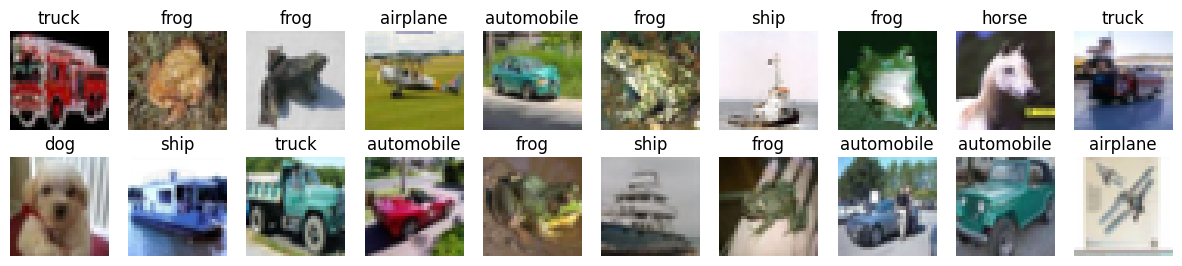

In [8]:
def show_random_samples(dataset, num_samples=20):
    indices = random.sample(range(len(dataset)), num_samples)
    plt.figure(figsize=(15, 3))
    for i, idx in enumerate(indices):
        img, label = dataset[idx]
        img = img.permute(1, 2, 0)  # CxHxW -> HxWxC for matplotlib
        plt.subplot(2, 10, i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(dataset.classes[label])  # show class name instead of label
    plt.show()

show_random_samples(train_set)

In [9]:
# Stack all images to compute mean/std
all_data = torch.stack([data[0] for data in train_set], dim=0)
mean = all_data.mean(dim=[0,2,3])
std = all_data.std(dim=[0,2,3])

print(f"CIFAR-10 Train Mean: {mean}")
print(f"CIFAR-10 Train Std: {std}")

CIFAR-10 Train Mean: tensor([0.4914, 0.4822, 0.4465])
CIFAR-10 Train Std: tensor([0.2470, 0.2435, 0.2616])


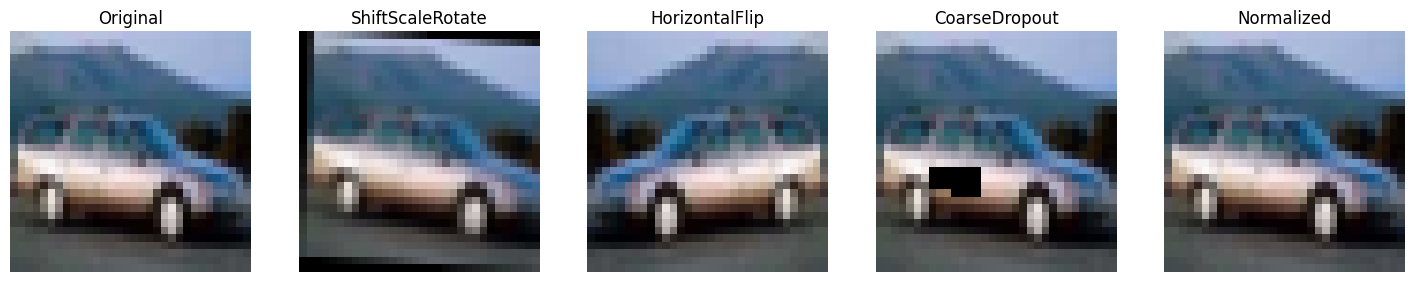

In [10]:
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True)
img, label = train_dataset[4]  # pick first image
img_np = np.array(img)  # convert to numpy

# -------------------------
# Define transformations
# -------------------------
ssr = A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=1.0)
hflip = A.HorizontalFlip(p=1.0)
coarse = A.CoarseDropout(
    max_holes=1, max_height=16, max_width=16,
    min_holes=1, min_height=16, min_width=16,
    fill_value=(int(0.4914*255), int(0.4822*255), int(0.4465*255)), p=1.0
)
mean = [0.4914, 0.4822, 0.4465]
std  = [0.2470, 0.2435, 0.2616]
normalize = A.Normalize(mean=mean, std=std)

# -------------------------
# Apply transformations step by step
# -------------------------
img_ssr = ssr(image=img_np)['image']
img_hflip = hflip(image=img_np)['image']
img_coarse = coarse(image=img_np)['image']

# Normalize for visualization (bring back to [0,1] for plotting)
img_norm = normalize(image=img_np)['image']
img_norm_vis = img_norm.copy()
for c in range(3):
    img_norm_vis[:,:,c] = img_norm_vis[:,:,c] * std[c] + mean[c]
img_norm_vis = np.clip(img_norm_vis, 0, 1)

# -------------------------
# Plot all in one row
# -------------------------
images = [img_np, img_ssr, img_hflip, img_coarse, img_norm_vis]
titles = ["Original", "ShiftScaleRotate", "HorizontalFlip", "CoarseDropout", "Normalized"]

plt.figure(figsize=(18,4))
for i, (im, title) in enumerate(zip(images, titles)):
    plt.subplot(1, 5, i+1)
    if title == "Normalized":
        plt.imshow(im)
    else:
        plt.imshow(im.astype(np.uint8))
    plt.axis("off")
    plt.title(title)
plt.show()


## Model - 1

In [11]:
## Let's Load the Data apply the transofrmation and train the model\

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
from PIL import Image
from tqdm import tqdm
import torch.nn.functional as F
from torchsummary import summary

# -----------------------
# 1. Albumentations transforms
# -----------------------
mean = [0.4914, 0.4822, 0.4465]
std  = [0.2470, 0.2435, 0.2616]

train_transform = A.Compose([
    A.HorizontalFlip(),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5),
    A.CoarseDropout(max_holes=1, max_height=16, max_width=16, min_holes=1, min_height=16, min_width=16,
                    fill_value=tuple([int(m*255) for m in mean]), mask_fill_value=None),
    A.Normalize(mean=mean, std=std),
    ToTensorV2()
])

test_transform = A.Compose([
    A.Normalize(mean=mean, std=std),
    ToTensorV2()
])

# Dataset wrapper for albumentations
class CIFAR10Alb(datasets.CIFAR10):
    def __getitem__(self, idx):
        img, target = self.data[idx], self.targets[idx]
        img = Image.fromarray(img)
        img = np.array(img)
        if self.transform:
            img = self.transform(image=img)['image']
        return img, target

train_dataset = CIFAR10Alb(root="./data", train=True, download=True, transform=train_transform)
test_dataset  = CIFAR10Alb(root="./data", train=False, transform=test_transform)

batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# -----------------------
# 2. Model Definition
# -----------------------
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()

        # Block 1
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU()
        )

        # Block 2 (Depthwise Separable)
        self.block2 = nn.Sequential(
            nn.Conv2d(16, 16, 3, padding=1, groups=16), # depthwise
            nn.Conv2d(16, 32, 1),                        # pointwise
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )

        # Block 3 (Dilated)
        self.block3 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=2, dilation=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        # Block 4 (stride 2)
        self.block4 = nn.Sequential(
            nn.Conv2d(64, 64, 3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        # GAP + FC
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(128, 10)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.gap(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# -----------------------
# 3. Training & Evaluation
# -----------------------

train_losses = []
test_losses = []
train_acc = []
test_acc = []

criterion = nn.CrossEntropyLoss()  # for CIFAR-10 logits

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader, desc=f"Epoch {epoch}")
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        # Update running accuracy
        pred = output.argmax(dim=1)
        correct += pred.eq(target).sum().item()
        processed += len(data)
        acc = 100 * correct / processed
        train_acc.append(acc)

        # Update tqdm description
        pbar.set_description(f"Loss={loss.item():.4f} Batch={batch_idx} Acc={acc:.2f}%")

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            test_loss += loss.item() * data.size(0)  # sum batch loss
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    acc = 100. * correct / len(test_loader.dataset)
    test_acc.append(acc)
    print(f"\nTest set: Avg Loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({acc:.2f}%)\n")


# -----------------------
# 4. Run Training
# -----------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device -->', device)
model = Model().to(device)
print(summary(model, input_size=(3, 32, 32)))
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

EPOCHS = 50
for epoch in range(1, EPOCHS + 1):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)



Device --> cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
       BatchNorm2d-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
            Conv2d-4           [-1, 16, 32, 32]           2,320
       BatchNorm2d-5           [-1, 16, 32, 32]              32
              ReLU-6           [-1, 16, 32, 32]               0
            Conv2d-7           [-1, 16, 32, 32]             160
            Conv2d-8           [-1, 32, 32, 32]             544
       BatchNorm2d-9           [-1, 32, 32, 32]              64
             ReLU-10           [-1, 32, 32, 32]               0
           Conv2d-11           [-1, 32, 32, 32]           9,248
      BatchNorm2d-12           [-1, 32, 32, 32]              64
             ReLU-13           [-1, 32, 32, 32]               0
           Conv2d-14   

Loss=1.7437 Batch=195 Acc=42.78%: 100%|██████████| 196/196 [00:24<00:00,  7.95it/s]



Test set: Avg Loss: 1.5542, Accuracy: 4178/10000 (41.78%)

EPOCH: 2


Loss=1.0496 Batch=195 Acc=57.16%: 100%|██████████| 196/196 [00:21<00:00,  9.03it/s]



Test set: Avg Loss: 1.2144, Accuracy: 5621/10000 (56.21%)

EPOCH: 3


Loss=1.0276 Batch=195 Acc=63.28%: 100%|██████████| 196/196 [00:22<00:00,  8.82it/s]



Test set: Avg Loss: 1.0388, Accuracy: 6253/10000 (62.53%)

EPOCH: 4


Loss=0.9437 Batch=195 Acc=66.78%: 100%|██████████| 196/196 [00:22<00:00,  8.67it/s]



Test set: Avg Loss: 1.1483, Accuracy: 6139/10000 (61.39%)

EPOCH: 5


Loss=0.8949 Batch=195 Acc=69.53%: 100%|██████████| 196/196 [00:22<00:00,  8.52it/s]



Test set: Avg Loss: 1.0277, Accuracy: 6374/10000 (63.74%)

EPOCH: 6


Loss=0.8517 Batch=195 Acc=71.66%: 100%|██████████| 196/196 [00:22<00:00,  8.63it/s]



Test set: Avg Loss: 0.7930, Accuracy: 7210/10000 (72.10%)

EPOCH: 7


Loss=0.8090 Batch=195 Acc=73.57%: 100%|██████████| 196/196 [00:22<00:00,  8.66it/s]



Test set: Avg Loss: 0.9222, Accuracy: 6703/10000 (67.03%)

EPOCH: 8


Loss=0.8306 Batch=195 Acc=74.66%: 100%|██████████| 196/196 [00:22<00:00,  8.63it/s]



Test set: Avg Loss: 0.7470, Accuracy: 7377/10000 (73.77%)

EPOCH: 9


Loss=0.6681 Batch=195 Acc=76.35%: 100%|██████████| 196/196 [00:22<00:00,  8.82it/s]



Test set: Avg Loss: 0.7635, Accuracy: 7403/10000 (74.03%)

EPOCH: 10


Loss=0.6967 Batch=195 Acc=77.33%: 100%|██████████| 196/196 [00:21<00:00,  9.00it/s]



Test set: Avg Loss: 0.7885, Accuracy: 7309/10000 (73.09%)

EPOCH: 11


Loss=0.6229 Batch=195 Acc=78.16%: 100%|██████████| 196/196 [00:22<00:00,  8.76it/s]



Test set: Avg Loss: 0.8359, Accuracy: 7197/10000 (71.97%)

EPOCH: 12


Loss=0.8630 Batch=195 Acc=78.71%: 100%|██████████| 196/196 [00:23<00:00,  8.45it/s]



Test set: Avg Loss: 0.7114, Accuracy: 7524/10000 (75.24%)

EPOCH: 13


Loss=0.8397 Batch=195 Acc=79.51%: 100%|██████████| 196/196 [00:23<00:00,  8.36it/s]



Test set: Avg Loss: 0.6438, Accuracy: 7774/10000 (77.74%)

EPOCH: 14


Loss=0.5918 Batch=195 Acc=80.02%: 100%|██████████| 196/196 [00:22<00:00,  8.74it/s]



Test set: Avg Loss: 0.8935, Accuracy: 7098/10000 (70.98%)

EPOCH: 15


Loss=0.5882 Batch=195 Acc=80.48%: 100%|██████████| 196/196 [00:22<00:00,  8.62it/s]



Test set: Avg Loss: 0.7479, Accuracy: 7607/10000 (76.07%)

EPOCH: 16


Loss=0.5715 Batch=195 Acc=80.99%: 100%|██████████| 196/196 [00:22<00:00,  8.60it/s]



Test set: Avg Loss: 0.6386, Accuracy: 7809/10000 (78.09%)

EPOCH: 17


Loss=0.5828 Batch=195 Acc=81.52%: 100%|██████████| 196/196 [00:23<00:00,  8.32it/s]



Test set: Avg Loss: 0.5656, Accuracy: 8029/10000 (80.29%)

EPOCH: 18


Loss=0.4338 Batch=195 Acc=81.76%: 100%|██████████| 196/196 [00:22<00:00,  8.70it/s]



Test set: Avg Loss: 0.6174, Accuracy: 7844/10000 (78.44%)

EPOCH: 19


Loss=0.5855 Batch=195 Acc=82.23%: 100%|██████████| 196/196 [00:22<00:00,  8.90it/s]



Test set: Avg Loss: 0.5915, Accuracy: 8044/10000 (80.44%)

EPOCH: 20


Loss=0.5119 Batch=195 Acc=82.73%: 100%|██████████| 196/196 [00:22<00:00,  8.87it/s]



Test set: Avg Loss: 0.7539, Accuracy: 7588/10000 (75.88%)

EPOCH: 21


Loss=0.2927 Batch=195 Acc=82.87%: 100%|██████████| 196/196 [00:22<00:00,  8.77it/s]



Test set: Avg Loss: 0.5785, Accuracy: 8047/10000 (80.47%)

EPOCH: 22


Loss=0.4117 Batch=195 Acc=83.36%: 100%|██████████| 196/196 [00:22<00:00,  8.58it/s]



Test set: Avg Loss: 0.6114, Accuracy: 8011/10000 (80.11%)

EPOCH: 23


Loss=0.5742 Batch=195 Acc=83.41%: 100%|██████████| 196/196 [00:22<00:00,  8.58it/s]



Test set: Avg Loss: 0.5506, Accuracy: 8094/10000 (80.94%)

EPOCH: 24


Loss=0.6649 Batch=195 Acc=83.72%: 100%|██████████| 196/196 [00:23<00:00,  8.29it/s]



Test set: Avg Loss: 0.6402, Accuracy: 7895/10000 (78.95%)

EPOCH: 25


Loss=0.5504 Batch=195 Acc=83.98%: 100%|██████████| 196/196 [00:22<00:00,  8.63it/s]



Test set: Avg Loss: 0.6155, Accuracy: 8000/10000 (80.00%)

EPOCH: 26


Loss=0.3207 Batch=195 Acc=84.18%: 100%|██████████| 196/196 [00:22<00:00,  8.57it/s]



Test set: Avg Loss: 0.5905, Accuracy: 8090/10000 (80.90%)

EPOCH: 27


Loss=0.4672 Batch=195 Acc=84.37%: 100%|██████████| 196/196 [00:22<00:00,  8.72it/s]



Test set: Avg Loss: 0.5318, Accuracy: 8186/10000 (81.86%)

EPOCH: 28


Loss=0.2765 Batch=195 Acc=84.74%: 100%|██████████| 196/196 [00:21<00:00,  9.06it/s]



Test set: Avg Loss: 0.5952, Accuracy: 8085/10000 (80.85%)

EPOCH: 29


Loss=0.3484 Batch=195 Acc=84.85%: 100%|██████████| 196/196 [00:21<00:00,  8.97it/s]



Test set: Avg Loss: 0.5833, Accuracy: 8087/10000 (80.87%)

EPOCH: 30


Loss=0.4153 Batch=195 Acc=84.95%: 100%|██████████| 196/196 [00:22<00:00,  8.56it/s]



Test set: Avg Loss: 0.5816, Accuracy: 8123/10000 (81.23%)

EPOCH: 31


Loss=0.4386 Batch=195 Acc=85.22%: 100%|██████████| 196/196 [00:22<00:00,  8.57it/s]



Test set: Avg Loss: 0.5960, Accuracy: 8128/10000 (81.28%)

EPOCH: 32


Loss=0.5925 Batch=195 Acc=85.73%: 100%|██████████| 196/196 [00:22<00:00,  8.55it/s]



Test set: Avg Loss: 0.6032, Accuracy: 8084/10000 (80.84%)

EPOCH: 33


Loss=0.3964 Batch=195 Acc=85.80%: 100%|██████████| 196/196 [00:22<00:00,  8.67it/s]



Test set: Avg Loss: 0.5925, Accuracy: 8015/10000 (80.15%)

EPOCH: 34


Loss=0.5260 Batch=195 Acc=85.83%: 100%|██████████| 196/196 [00:22<00:00,  8.63it/s]



Test set: Avg Loss: 0.4902, Accuracy: 8345/10000 (83.45%)

EPOCH: 35


Loss=0.4574 Batch=195 Acc=86.24%: 100%|██████████| 196/196 [00:22<00:00,  8.72it/s]



Test set: Avg Loss: 0.4777, Accuracy: 8396/10000 (83.96%)

EPOCH: 36


Loss=0.3694 Batch=195 Acc=85.95%: 100%|██████████| 196/196 [00:23<00:00,  8.27it/s]



Test set: Avg Loss: 0.5142, Accuracy: 8318/10000 (83.18%)

EPOCH: 37


Loss=0.3483 Batch=195 Acc=86.25%: 100%|██████████| 196/196 [00:21<00:00,  8.91it/s]



Test set: Avg Loss: 0.5201, Accuracy: 8295/10000 (82.95%)

EPOCH: 38


Loss=0.5348 Batch=195 Acc=86.71%: 100%|██████████| 196/196 [00:21<00:00,  8.92it/s]



Test set: Avg Loss: 0.5878, Accuracy: 8105/10000 (81.05%)

EPOCH: 39


Loss=0.2863 Batch=195 Acc=86.48%: 100%|██████████| 196/196 [00:22<00:00,  8.64it/s]



Test set: Avg Loss: 0.5256, Accuracy: 8264/10000 (82.64%)

EPOCH: 40


Loss=0.3687 Batch=195 Acc=86.59%: 100%|██████████| 196/196 [00:22<00:00,  8.62it/s]



Test set: Avg Loss: 0.4885, Accuracy: 8364/10000 (83.64%)

EPOCH: 41


Loss=0.3218 Batch=195 Acc=86.87%: 100%|██████████| 196/196 [00:22<00:00,  8.55it/s]



Test set: Avg Loss: 0.5626, Accuracy: 8148/10000 (81.48%)

EPOCH: 42


Loss=0.5346 Batch=195 Acc=86.90%: 100%|██████████| 196/196 [00:22<00:00,  8.68it/s]



Test set: Avg Loss: 0.5542, Accuracy: 8167/10000 (81.67%)

EPOCH: 43


Loss=0.5921 Batch=195 Acc=86.92%: 100%|██████████| 196/196 [00:22<00:00,  8.71it/s]



Test set: Avg Loss: 0.5022, Accuracy: 8350/10000 (83.50%)

EPOCH: 44


Loss=0.4481 Batch=195 Acc=87.13%: 100%|██████████| 196/196 [00:22<00:00,  8.73it/s]



Test set: Avg Loss: 0.5648, Accuracy: 8167/10000 (81.67%)

EPOCH: 45


Loss=0.3974 Batch=195 Acc=87.22%: 100%|██████████| 196/196 [00:21<00:00,  9.03it/s]



Test set: Avg Loss: 0.5420, Accuracy: 8232/10000 (82.32%)

EPOCH: 46


Loss=0.3364 Batch=195 Acc=87.36%: 100%|██████████| 196/196 [00:21<00:00,  8.98it/s]



Test set: Avg Loss: 0.4762, Accuracy: 8409/10000 (84.09%)

EPOCH: 47


Loss=0.4056 Batch=195 Acc=87.46%: 100%|██████████| 196/196 [00:22<00:00,  8.85it/s]



Test set: Avg Loss: 0.5232, Accuracy: 8286/10000 (82.86%)

EPOCH: 48


Loss=0.3498 Batch=195 Acc=87.59%: 100%|██████████| 196/196 [00:23<00:00,  8.19it/s]



Test set: Avg Loss: 0.4593, Accuracy: 8423/10000 (84.23%)

EPOCH: 49


Loss=0.4644 Batch=195 Acc=87.64%: 100%|██████████| 196/196 [00:22<00:00,  8.61it/s]



Test set: Avg Loss: 0.5618, Accuracy: 8284/10000 (82.84%)

EPOCH: 50


Loss=0.3232 Batch=195 Acc=87.85%: 100%|██████████| 196/196 [00:22<00:00,  8.57it/s]



Test set: Avg Loss: 0.5348, Accuracy: 8246/10000 (82.46%)



## Model - 2

- Add Dropout to reduce overfitting
- Add StePLR scheduler
- Increase the RF

In [12]:
#### Increase the rf , Add dropout , Add scheduler per 15 epoch

class Model(nn.Module):
    def __init__(self, drop_prob=0.25):
        super().__init__()
        # Block 1
        self.block1 = nn.Sequential(
            nn.Conv2d(3,16,3,padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16,16,3,padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout2d(p=drop_prob)
        )
        # Block 2: depthwise
        self.block2 = nn.Sequential(
            nn.Conv2d(16,16,3,padding=1, groups=16, bias=False),  # depthwise
            nn.Conv2d(16,32,1, bias=False),                        # pointwise
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32,32,3,padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout2d(p=drop_prob)
        )
        # Block 3: dilated
        self.block3 = nn.Sequential(
            nn.Conv2d(32,64,3,padding=2,dilation=2, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64,64,3,padding=2,dilation=2, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64,64,3,padding=2,dilation=2, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout2d(p=drop_prob)
        )
        # Block 4: stride + more dilation
        self.block4 = nn.Sequential(
            nn.Conv2d(64,64,3,stride=2,padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64,128,3,padding=2,dilation=2, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128,128,3,padding=2,dilation=2, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout2d(p=drop_prob)
        )
        # GAP + FC
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(128,10)

    def forward(self,x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.gap(x)
        x = x.view(x.size(0),-1)
        x = self.fc(x)
        return x

# 3. Training & Evaluation
# -----------------------
from torchsummary import summary
train_losses = []
test_losses = []
train_acc = []
test_acc = []

criterion = nn.CrossEntropyLoss()  # for CIFAR-10 logits

model = Model().to(device)
print(summary(model, input_size=(3, 32, 32)))
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

EPOCHS = 50
for epoch in range(1, EPOCHS + 1):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
       BatchNorm2d-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
            Conv2d-4           [-1, 16, 32, 32]           2,304
       BatchNorm2d-5           [-1, 16, 32, 32]              32
              ReLU-6           [-1, 16, 32, 32]               0
         Dropout2d-7           [-1, 16, 32, 32]               0
            Conv2d-8           [-1, 16, 32, 32]             144
            Conv2d-9           [-1, 32, 32, 32]             512
      BatchNorm2d-10           [-1, 32, 32, 32]              64
             ReLU-11           [-1, 32, 32, 32]               0
           Conv2d-12           [-1, 32, 32, 32]           9,216
      BatchNorm2d-13           [-1, 32, 32, 32]              64
             ReLU-14           [-1, 32,

Loss=1.5252 Batch=195 Acc=29.13%: 100%|██████████| 196/196 [00:27<00:00,  7.23it/s]



Test set: Avg Loss: 1.5608, Accuracy: 4135/10000 (41.35%)

EPOCH: 2


Loss=1.6409 Batch=195 Acc=40.82%: 100%|██████████| 196/196 [00:26<00:00,  7.29it/s]



Test set: Avg Loss: 1.3561, Accuracy: 5004/10000 (50.04%)

EPOCH: 3


Loss=1.4245 Batch=195 Acc=46.68%: 100%|██████████| 196/196 [00:26<00:00,  7.32it/s]



Test set: Avg Loss: 1.2466, Accuracy: 5522/10000 (55.22%)

EPOCH: 4


Loss=1.2069 Batch=195 Acc=51.27%: 100%|██████████| 196/196 [00:27<00:00,  7.14it/s]



Test set: Avg Loss: 1.1278, Accuracy: 5972/10000 (59.72%)

EPOCH: 5


Loss=1.2156 Batch=195 Acc=55.19%: 100%|██████████| 196/196 [00:26<00:00,  7.29it/s]



Test set: Avg Loss: 1.0602, Accuracy: 6230/10000 (62.30%)

EPOCH: 6


Loss=1.0200 Batch=195 Acc=58.64%: 100%|██████████| 196/196 [00:26<00:00,  7.29it/s]



Test set: Avg Loss: 0.9539, Accuracy: 6556/10000 (65.56%)

EPOCH: 7


Loss=1.1238 Batch=195 Acc=61.25%: 100%|██████████| 196/196 [00:26<00:00,  7.28it/s]



Test set: Avg Loss: 0.8815, Accuracy: 6847/10000 (68.47%)

EPOCH: 8


Loss=1.0288 Batch=195 Acc=63.47%: 100%|██████████| 196/196 [00:27<00:00,  7.21it/s]



Test set: Avg Loss: 0.8356, Accuracy: 6997/10000 (69.97%)

EPOCH: 9


Loss=1.1998 Batch=195 Acc=65.35%: 100%|██████████| 196/196 [00:27<00:00,  7.11it/s]



Test set: Avg Loss: 0.7724, Accuracy: 7252/10000 (72.52%)

EPOCH: 10


Loss=0.8107 Batch=195 Acc=66.86%: 100%|██████████| 196/196 [00:26<00:00,  7.28it/s]



Test set: Avg Loss: 0.7714, Accuracy: 7222/10000 (72.22%)

EPOCH: 11


Loss=0.8377 Batch=195 Acc=68.25%: 100%|██████████| 196/196 [00:26<00:00,  7.29it/s]



Test set: Avg Loss: 0.7037, Accuracy: 7522/10000 (75.22%)

EPOCH: 12


Loss=0.8483 Batch=195 Acc=69.65%: 100%|██████████| 196/196 [00:27<00:00,  7.23it/s]



Test set: Avg Loss: 0.6683, Accuracy: 7603/10000 (76.03%)

EPOCH: 13


Loss=0.9835 Batch=195 Acc=70.81%: 100%|██████████| 196/196 [00:27<00:00,  7.24it/s]



Test set: Avg Loss: 0.6500, Accuracy: 7705/10000 (77.05%)

EPOCH: 14


Loss=0.7506 Batch=195 Acc=71.97%: 100%|██████████| 196/196 [00:26<00:00,  7.26it/s]



Test set: Avg Loss: 0.6559, Accuracy: 7710/10000 (77.10%)

EPOCH: 15


Loss=0.7499 Batch=195 Acc=72.56%: 100%|██████████| 196/196 [00:27<00:00,  7.13it/s]



Test set: Avg Loss: 0.6282, Accuracy: 7784/10000 (77.84%)

EPOCH: 16


Loss=0.8239 Batch=195 Acc=73.28%: 100%|██████████| 196/196 [00:27<00:00,  7.15it/s]



Test set: Avg Loss: 0.5969, Accuracy: 7914/10000 (79.14%)

EPOCH: 17


Loss=0.7830 Batch=195 Acc=73.98%: 100%|██████████| 196/196 [00:27<00:00,  7.20it/s]



Test set: Avg Loss: 0.5950, Accuracy: 7904/10000 (79.04%)

EPOCH: 18


Loss=0.8884 Batch=195 Acc=74.45%: 100%|██████████| 196/196 [00:27<00:00,  7.23it/s]



Test set: Avg Loss: 0.6133, Accuracy: 7891/10000 (78.91%)

EPOCH: 19


Loss=0.7006 Batch=195 Acc=75.14%: 100%|██████████| 196/196 [00:28<00:00,  6.99it/s]



Test set: Avg Loss: 0.5775, Accuracy: 7994/10000 (79.94%)

EPOCH: 20


Loss=0.5822 Batch=195 Acc=75.56%: 100%|██████████| 196/196 [00:27<00:00,  7.13it/s]



Test set: Avg Loss: 0.5626, Accuracy: 8011/10000 (80.11%)

EPOCH: 21


Loss=0.5754 Batch=195 Acc=76.26%: 100%|██████████| 196/196 [00:27<00:00,  7.17it/s]



Test set: Avg Loss: 0.5380, Accuracy: 8147/10000 (81.47%)

EPOCH: 22


Loss=0.6423 Batch=195 Acc=76.60%: 100%|██████████| 196/196 [00:27<00:00,  7.20it/s]



Test set: Avg Loss: 0.5801, Accuracy: 7987/10000 (79.87%)

EPOCH: 23


Loss=0.7008 Batch=195 Acc=77.06%: 100%|██████████| 196/196 [00:27<00:00,  7.21it/s]



Test set: Avg Loss: 0.5707, Accuracy: 8030/10000 (80.30%)

EPOCH: 24


Loss=0.5951 Batch=195 Acc=77.36%: 100%|██████████| 196/196 [00:28<00:00,  6.93it/s]



Test set: Avg Loss: 0.5401, Accuracy: 8130/10000 (81.30%)

EPOCH: 25


Loss=0.6791 Batch=195 Acc=77.89%: 100%|██████████| 196/196 [00:27<00:00,  7.17it/s]



Test set: Avg Loss: 0.5640, Accuracy: 8037/10000 (80.37%)

EPOCH: 26


Loss=0.7828 Batch=195 Acc=78.22%: 100%|██████████| 196/196 [00:27<00:00,  7.20it/s]



Test set: Avg Loss: 0.5307, Accuracy: 8181/10000 (81.81%)

EPOCH: 27


Loss=0.6565 Batch=195 Acc=78.44%: 100%|██████████| 196/196 [00:27<00:00,  7.17it/s]



Test set: Avg Loss: 0.5141, Accuracy: 8204/10000 (82.04%)

EPOCH: 28


Loss=0.5607 Batch=195 Acc=78.82%: 100%|██████████| 196/196 [00:27<00:00,  7.06it/s]



Test set: Avg Loss: 0.4768, Accuracy: 8349/10000 (83.49%)

EPOCH: 29


Loss=0.5509 Batch=195 Acc=78.76%: 100%|██████████| 196/196 [00:28<00:00,  6.98it/s]



Test set: Avg Loss: 0.5277, Accuracy: 8211/10000 (82.11%)

EPOCH: 30


Loss=0.5225 Batch=195 Acc=79.45%: 100%|██████████| 196/196 [00:27<00:00,  7.19it/s]



Test set: Avg Loss: 0.4821, Accuracy: 8324/10000 (83.24%)

EPOCH: 31


Loss=0.4590 Batch=195 Acc=79.61%: 100%|██████████| 196/196 [00:27<00:00,  7.22it/s]



Test set: Avg Loss: 0.4522, Accuracy: 8453/10000 (84.53%)

EPOCH: 32


Loss=0.5863 Batch=195 Acc=79.56%: 100%|██████████| 196/196 [00:27<00:00,  7.10it/s]



Test set: Avg Loss: 0.5130, Accuracy: 8227/10000 (82.27%)

EPOCH: 33


Loss=0.5598 Batch=195 Acc=80.39%: 100%|██████████| 196/196 [00:27<00:00,  7.23it/s]



Test set: Avg Loss: 0.4597, Accuracy: 8399/10000 (83.99%)

EPOCH: 34


Loss=0.6535 Batch=195 Acc=80.34%: 100%|██████████| 196/196 [00:27<00:00,  7.21it/s]



Test set: Avg Loss: 0.4681, Accuracy: 8403/10000 (84.03%)

EPOCH: 35


Loss=0.7473 Batch=195 Acc=80.56%: 100%|██████████| 196/196 [00:27<00:00,  7.23it/s]



Test set: Avg Loss: 0.4519, Accuracy: 8451/10000 (84.51%)

EPOCH: 36


Loss=0.5793 Batch=195 Acc=80.73%: 100%|██████████| 196/196 [00:27<00:00,  7.11it/s]



Test set: Avg Loss: 0.4422, Accuracy: 8469/10000 (84.69%)

EPOCH: 37


Loss=0.4677 Batch=195 Acc=80.97%: 100%|██████████| 196/196 [00:26<00:00,  7.28it/s]



Test set: Avg Loss: 0.4567, Accuracy: 8382/10000 (83.82%)

EPOCH: 38


Loss=0.6183 Batch=195 Acc=81.24%: 100%|██████████| 196/196 [00:27<00:00,  7.23it/s]



Test set: Avg Loss: 0.4386, Accuracy: 8460/10000 (84.60%)

EPOCH: 39


Loss=0.6922 Batch=195 Acc=81.39%: 100%|██████████| 196/196 [00:28<00:00,  7.00it/s]



Test set: Avg Loss: 0.4312, Accuracy: 8510/10000 (85.10%)

EPOCH: 40


Loss=0.4919 Batch=195 Acc=81.48%: 100%|██████████| 196/196 [00:27<00:00,  7.21it/s]



Test set: Avg Loss: 0.4334, Accuracy: 8501/10000 (85.01%)

EPOCH: 41


Loss=0.4917 Batch=195 Acc=81.96%: 100%|██████████| 196/196 [00:27<00:00,  7.21it/s]



Test set: Avg Loss: 0.4263, Accuracy: 8514/10000 (85.14%)

EPOCH: 42


Loss=0.5620 Batch=195 Acc=81.91%: 100%|██████████| 196/196 [00:27<00:00,  7.25it/s]



Test set: Avg Loss: 0.4133, Accuracy: 8577/10000 (85.77%)

EPOCH: 43


Loss=0.4430 Batch=195 Acc=82.07%: 100%|██████████| 196/196 [00:27<00:00,  7.25it/s]



Test set: Avg Loss: 0.4148, Accuracy: 8579/10000 (85.79%)

EPOCH: 44


Loss=0.6159 Batch=195 Acc=82.15%: 100%|██████████| 196/196 [00:27<00:00,  7.19it/s]



Test set: Avg Loss: 0.4065, Accuracy: 8619/10000 (86.19%)

EPOCH: 45


Loss=0.5736 Batch=195 Acc=82.62%: 100%|██████████| 196/196 [00:27<00:00,  7.21it/s]



Test set: Avg Loss: 0.4275, Accuracy: 8509/10000 (85.09%)

EPOCH: 46


Loss=0.5062 Batch=195 Acc=82.59%: 100%|██████████| 196/196 [00:27<00:00,  7.21it/s]



Test set: Avg Loss: 0.4448, Accuracy: 8437/10000 (84.37%)

EPOCH: 47


Loss=0.3567 Batch=195 Acc=82.74%: 100%|██████████| 196/196 [00:33<00:00,  5.93it/s]



Test set: Avg Loss: 0.4212, Accuracy: 8547/10000 (85.47%)

EPOCH: 48


Loss=0.5667 Batch=195 Acc=82.87%: 100%|██████████| 196/196 [00:27<00:00,  7.18it/s]



Test set: Avg Loss: 0.4352, Accuracy: 8488/10000 (84.88%)

EPOCH: 49


Loss=0.5302 Batch=195 Acc=83.18%: 100%|██████████| 196/196 [00:27<00:00,  7.12it/s]



Test set: Avg Loss: 0.4159, Accuracy: 8577/10000 (85.77%)

EPOCH: 50


Loss=0.4782 Batch=195 Acc=83.30%: 100%|██████████| 196/196 [00:27<00:00,  7.11it/s]



Test set: Avg Loss: 0.4002, Accuracy: 8636/10000 (86.36%)



### Model - 3

In [13]:
class Model(nn.Module):
    def __init__(self, drop_prob=0.1):
        super().__init__()
        # Block 1
        self.block1 = nn.Sequential(
            nn.Conv2d(3,16,3,padding=1,bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16,16,3,padding=1,bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout2d(drop_prob)
        )

        # Block 2 (Depthwise + 1x1 + normal)
        self.block2 = nn.Sequential(
            nn.Conv2d(16,16,3,padding=1,groups=16,bias=False), # depthwise
            nn.Conv2d(16,24,1,bias=False),                       # pointwise
            nn.BatchNorm2d(24),
            nn.ReLU(),
            nn.Conv2d(24,24,3,padding=1,bias=False),
            nn.BatchNorm2d(24),
            nn.ReLU(),
            nn.Conv2d(24,24,1,bias=False), # 1x1 mix
            nn.Dropout2d(drop_prob)
        )

        # Block 3 (Dilated)
        self.block3 = nn.Sequential(
            nn.Conv2d(24,36,3,padding=2,dilation=2,bias=False),
            nn.BatchNorm2d(36),
            nn.ReLU(),
            nn.Conv2d(36,36,3,padding=2,dilation=2,bias=False),
            nn.BatchNorm2d(36),
            nn.ReLU(),
            nn.Conv2d(36,36,3,padding=1,bias=False),
            nn.BatchNorm2d(36),
            nn.ReLU(),
            nn.Conv2d(36,36,1,bias=False),
            nn.Dropout2d(drop_prob)
        )

        # Block 4 (Stride + dilated)
        self.block4 = nn.Sequential(
            nn.Conv2d(36,48,3,stride=2,padding=1,bias=False),
            nn.BatchNorm2d(48),
            nn.ReLU(),
            nn.Conv2d(48,64,3,padding=2,dilation=2,bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64,64,3,padding=2,dilation=2,bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64,64,3,padding=1,bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64,64,1,bias=False),
            nn.Dropout2d(drop_prob)
        )

        # GAP + FC
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(64,10)

    def forward(self,x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.gap(x)
        x = x.view(x.size(0),-1)
        x = self.fc(x)
        return x


# 3. Training & Evaluation
# -----------------------
from torch.optim.lr_scheduler import StepLR
train_losses = []
test_losses = []
train_acc = []
test_acc = []

criterion = nn.CrossEntropyLoss()  # for CIFAR-10 logits

model = Model().to(device)
print(summary(model, input_size=(3, 32, 32)))
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=15, gamma=0.1)  # reduce LR by 10x every 15 epochs

EPOCHS = 50
for epoch in range(1, EPOCHS + 1):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    scheduler.step()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
       BatchNorm2d-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
            Conv2d-4           [-1, 16, 32, 32]           2,304
       BatchNorm2d-5           [-1, 16, 32, 32]              32
              ReLU-6           [-1, 16, 32, 32]               0
         Dropout2d-7           [-1, 16, 32, 32]               0
            Conv2d-8           [-1, 16, 32, 32]             144
            Conv2d-9           [-1, 24, 32, 32]             384
      BatchNorm2d-10           [-1, 24, 32, 32]              48
             ReLU-11           [-1, 24, 32, 32]               0
           Conv2d-12           [-1, 24, 32, 32]           5,184
      BatchNorm2d-13           [-1, 24, 32, 32]              48
             ReLU-14           [-1, 24,

Loss=1.4604 Batch=195 Acc=34.43%: 100%|██████████| 196/196 [00:24<00:00,  8.08it/s]



Test set: Avg Loss: 1.4717, Accuracy: 4464/10000 (44.64%)

EPOCH: 2


Loss=1.0268 Batch=195 Acc=50.22%: 100%|██████████| 196/196 [00:24<00:00,  8.11it/s]



Test set: Avg Loss: 1.2595, Accuracy: 5328/10000 (53.28%)

EPOCH: 3


Loss=0.9104 Batch=195 Acc=58.14%: 100%|██████████| 196/196 [00:24<00:00,  8.11it/s]



Test set: Avg Loss: 1.0428, Accuracy: 6210/10000 (62.10%)

EPOCH: 4


Loss=0.9594 Batch=195 Acc=62.33%: 100%|██████████| 196/196 [00:24<00:00,  8.15it/s]



Test set: Avg Loss: 1.0421, Accuracy: 6224/10000 (62.24%)

EPOCH: 5


Loss=1.0310 Batch=195 Acc=65.79%: 100%|██████████| 196/196 [00:23<00:00,  8.32it/s]



Test set: Avg Loss: 0.8679, Accuracy: 6849/10000 (68.49%)

EPOCH: 6


Loss=0.9077 Batch=195 Acc=68.61%: 100%|██████████| 196/196 [00:23<00:00,  8.20it/s]



Test set: Avg Loss: 0.8574, Accuracy: 6928/10000 (69.28%)

EPOCH: 7


Loss=0.9592 Batch=195 Acc=71.13%: 100%|██████████| 196/196 [00:23<00:00,  8.34it/s]



Test set: Avg Loss: 0.8706, Accuracy: 6993/10000 (69.93%)

EPOCH: 8


Loss=0.8887 Batch=195 Acc=73.03%: 100%|██████████| 196/196 [00:24<00:00,  7.92it/s]



Test set: Avg Loss: 0.7345, Accuracy: 7424/10000 (74.24%)

EPOCH: 9


Loss=0.7053 Batch=195 Acc=74.45%: 100%|██████████| 196/196 [00:24<00:00,  8.10it/s]



Test set: Avg Loss: 0.6577, Accuracy: 7700/10000 (77.00%)

EPOCH: 10


Loss=0.5625 Batch=195 Acc=75.61%: 100%|██████████| 196/196 [00:24<00:00,  8.05it/s]



Test set: Avg Loss: 0.6621, Accuracy: 7721/10000 (77.21%)

EPOCH: 11


Loss=0.6461 Batch=195 Acc=76.75%: 100%|██████████| 196/196 [00:24<00:00,  7.89it/s]



Test set: Avg Loss: 0.5954, Accuracy: 7939/10000 (79.39%)

EPOCH: 12


Loss=0.5788 Batch=195 Acc=77.51%: 100%|██████████| 196/196 [00:24<00:00,  7.94it/s]



Test set: Avg Loss: 0.6745, Accuracy: 7744/10000 (77.44%)

EPOCH: 13


Loss=0.6911 Batch=195 Acc=78.01%: 100%|██████████| 196/196 [00:24<00:00,  7.99it/s]



Test set: Avg Loss: 0.5949, Accuracy: 8040/10000 (80.40%)

EPOCH: 14


Loss=0.7413 Batch=195 Acc=78.82%: 100%|██████████| 196/196 [00:23<00:00,  8.22it/s]



Test set: Avg Loss: 0.5865, Accuracy: 7977/10000 (79.77%)

EPOCH: 15


Loss=0.3458 Batch=195 Acc=79.44%: 100%|██████████| 196/196 [00:24<00:00,  8.12it/s]



Test set: Avg Loss: 0.5587, Accuracy: 8084/10000 (80.84%)

EPOCH: 16


Loss=0.3162 Batch=195 Acc=81.40%: 100%|██████████| 196/196 [00:24<00:00,  8.02it/s]



Test set: Avg Loss: 0.4744, Accuracy: 8351/10000 (83.51%)

EPOCH: 17


Loss=0.5592 Batch=195 Acc=82.17%: 100%|██████████| 196/196 [00:24<00:00,  7.99it/s]



Test set: Avg Loss: 0.4772, Accuracy: 8315/10000 (83.15%)

EPOCH: 18


Loss=0.7591 Batch=195 Acc=82.55%: 100%|██████████| 196/196 [00:23<00:00,  8.22it/s]



Test set: Avg Loss: 0.4647, Accuracy: 8385/10000 (83.85%)

EPOCH: 19


Loss=0.6801 Batch=195 Acc=82.53%: 100%|██████████| 196/196 [00:23<00:00,  8.21it/s]



Test set: Avg Loss: 0.4620, Accuracy: 8411/10000 (84.11%)

EPOCH: 20


Loss=0.3537 Batch=195 Acc=83.10%: 100%|██████████| 196/196 [00:23<00:00,  8.40it/s]



Test set: Avg Loss: 0.4603, Accuracy: 8403/10000 (84.03%)

EPOCH: 21


Loss=0.7030 Batch=195 Acc=82.93%: 100%|██████████| 196/196 [00:24<00:00,  7.93it/s]



Test set: Avg Loss: 0.4655, Accuracy: 8408/10000 (84.08%)

EPOCH: 22


Loss=0.3689 Batch=195 Acc=82.96%: 100%|██████████| 196/196 [00:23<00:00,  8.20it/s]



Test set: Avg Loss: 0.4589, Accuracy: 8402/10000 (84.02%)

EPOCH: 23


Loss=0.3601 Batch=195 Acc=83.16%: 100%|██████████| 196/196 [00:24<00:00,  8.12it/s]



Test set: Avg Loss: 0.4591, Accuracy: 8404/10000 (84.04%)

EPOCH: 24


Loss=0.5782 Batch=195 Acc=83.40%: 100%|██████████| 196/196 [00:23<00:00,  8.28it/s]



Test set: Avg Loss: 0.4563, Accuracy: 8445/10000 (84.45%)

EPOCH: 25


Loss=0.4376 Batch=195 Acc=83.30%: 100%|██████████| 196/196 [00:23<00:00,  8.37it/s]



Test set: Avg Loss: 0.4548, Accuracy: 8420/10000 (84.20%)

EPOCH: 26


Loss=0.4966 Batch=195 Acc=83.49%: 100%|██████████| 196/196 [00:23<00:00,  8.27it/s]



Test set: Avg Loss: 0.4512, Accuracy: 8447/10000 (84.47%)

EPOCH: 27


Loss=0.6119 Batch=195 Acc=83.56%: 100%|██████████| 196/196 [00:24<00:00,  8.04it/s]



Test set: Avg Loss: 0.4530, Accuracy: 8448/10000 (84.48%)

EPOCH: 28


Loss=0.3974 Batch=195 Acc=83.52%: 100%|██████████| 196/196 [00:23<00:00,  8.31it/s]



Test set: Avg Loss: 0.4486, Accuracy: 8461/10000 (84.61%)

EPOCH: 29


Loss=0.4778 Batch=195 Acc=83.64%: 100%|██████████| 196/196 [00:23<00:00,  8.26it/s]



Test set: Avg Loss: 0.4464, Accuracy: 8458/10000 (84.58%)

EPOCH: 30


Loss=0.3987 Batch=195 Acc=83.97%: 100%|██████████| 196/196 [00:23<00:00,  8.17it/s]



Test set: Avg Loss: 0.4510, Accuracy: 8461/10000 (84.61%)

EPOCH: 31


Loss=0.4902 Batch=195 Acc=84.08%: 100%|██████████| 196/196 [00:23<00:00,  8.35it/s]



Test set: Avg Loss: 0.4458, Accuracy: 8462/10000 (84.62%)

EPOCH: 32


Loss=0.5112 Batch=195 Acc=83.96%: 100%|██████████| 196/196 [00:25<00:00,  7.78it/s]



Test set: Avg Loss: 0.4425, Accuracy: 8475/10000 (84.75%)

EPOCH: 33


Loss=0.6752 Batch=195 Acc=84.04%: 100%|██████████| 196/196 [00:24<00:00,  8.12it/s]



Test set: Avg Loss: 0.4421, Accuracy: 8475/10000 (84.75%)

EPOCH: 34


Loss=0.4068 Batch=195 Acc=83.94%: 100%|██████████| 196/196 [00:24<00:00,  8.10it/s]



Test set: Avg Loss: 0.4403, Accuracy: 8486/10000 (84.86%)

EPOCH: 35


Loss=0.3141 Batch=195 Acc=84.05%: 100%|██████████| 196/196 [00:25<00:00,  7.83it/s]



Test set: Avg Loss: 0.4416, Accuracy: 8481/10000 (84.81%)

EPOCH: 36


Loss=0.4625 Batch=195 Acc=84.32%: 100%|██████████| 196/196 [00:24<00:00,  7.89it/s]



Test set: Avg Loss: 0.4396, Accuracy: 8490/10000 (84.90%)

EPOCH: 37


Loss=0.3189 Batch=195 Acc=84.36%: 100%|██████████| 196/196 [00:24<00:00,  7.89it/s]



Test set: Avg Loss: 0.4401, Accuracy: 8480/10000 (84.80%)

EPOCH: 38


Loss=0.5683 Batch=195 Acc=84.32%: 100%|██████████| 196/196 [00:24<00:00,  7.84it/s]



Test set: Avg Loss: 0.4420, Accuracy: 8486/10000 (84.86%)

EPOCH: 39


Loss=0.4547 Batch=195 Acc=84.25%: 100%|██████████| 196/196 [00:24<00:00,  7.86it/s]



Test set: Avg Loss: 0.4414, Accuracy: 8489/10000 (84.89%)

EPOCH: 40


Loss=0.4263 Batch=195 Acc=84.05%: 100%|██████████| 196/196 [00:25<00:00,  7.72it/s]



Test set: Avg Loss: 0.4385, Accuracy: 8486/10000 (84.86%)

EPOCH: 41


Loss=0.2867 Batch=195 Acc=84.07%: 100%|██████████| 196/196 [00:24<00:00,  7.84it/s]



Test set: Avg Loss: 0.4390, Accuracy: 8496/10000 (84.96%)

EPOCH: 42


Loss=0.3737 Batch=195 Acc=84.17%: 100%|██████████| 196/196 [00:24<00:00,  7.87it/s]



Test set: Avg Loss: 0.4405, Accuracy: 8484/10000 (84.84%)

EPOCH: 43


Loss=0.4615 Batch=195 Acc=84.32%: 100%|██████████| 196/196 [00:26<00:00,  7.51it/s]



Test set: Avg Loss: 0.4400, Accuracy: 8485/10000 (84.85%)

EPOCH: 44


Loss=0.4392 Batch=195 Acc=84.20%: 100%|██████████| 196/196 [00:24<00:00,  7.90it/s]



Test set: Avg Loss: 0.4392, Accuracy: 8493/10000 (84.93%)

EPOCH: 45


Loss=0.6459 Batch=195 Acc=84.33%: 100%|██████████| 196/196 [00:24<00:00,  7.96it/s]



Test set: Avg Loss: 0.4379, Accuracy: 8499/10000 (84.99%)

EPOCH: 46


Loss=0.5537 Batch=195 Acc=84.37%: 100%|██████████| 196/196 [00:25<00:00,  7.79it/s]



Test set: Avg Loss: 0.4388, Accuracy: 8500/10000 (85.00%)

EPOCH: 47


Loss=0.8474 Batch=195 Acc=84.30%: 100%|██████████| 196/196 [00:24<00:00,  7.95it/s]



Test set: Avg Loss: 0.4392, Accuracy: 8494/10000 (84.94%)

EPOCH: 48


Loss=0.4082 Batch=195 Acc=84.36%: 100%|██████████| 196/196 [00:24<00:00,  7.95it/s]



Test set: Avg Loss: 0.4386, Accuracy: 8502/10000 (85.02%)

EPOCH: 49


Loss=0.4074 Batch=195 Acc=84.39%: 100%|██████████| 196/196 [00:25<00:00,  7.74it/s]



Test set: Avg Loss: 0.4382, Accuracy: 8497/10000 (84.97%)

EPOCH: 50


Loss=0.3731 Batch=195 Acc=84.34%: 100%|██████████| 196/196 [00:24<00:00,  7.99it/s]



Test set: Avg Loss: 0.4386, Accuracy: 8501/10000 (85.01%)



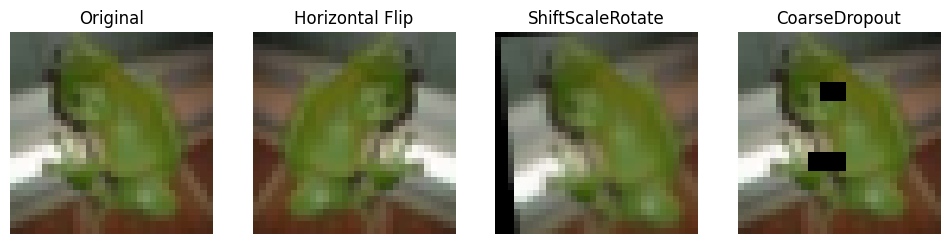

In [23]:
import torch
import torchvision
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
import numpy as np

# Load CIFAR-10 dataset (test set)
cifar10 = torchvision.datasets.CIFAR10(root='./data', train=False, download=True)
img, label = cifar10[7]  # pick first image
img_np = np.array(img)   # convert PIL image to numpy

# Define separate augmentation pipelines
horizontal_flip = A.Compose([A.HorizontalFlip(p=1.0)])
shift_scale_rotate = A.Compose([A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=1.0)])
coarse_dropout = A.Compose([
    A.CoarseDropout(max_holes=1, max_height=16, max_width=16,
                    min_holes=1, min_height=16, min_width=16,
                    fill_value=img_np.mean(), mask_fill_value=None, p=1.0)
])

# Apply augmentations
img_hflip = horizontal_flip(image=img_np)['image']
img_ssr = shift_scale_rotate(image=img_np)['image']
img_dropout = coarse_dropout(image=img_np)['image']

# Display original and augmented images
fig, axes = plt.subplots(1, 4, figsize=(12,4))
axes[0].imshow(img_np)
axes[0].set_title("Original")
axes[0].axis('off')

axes[1].imshow(img_hflip.astype(np.uint8))
axes[1].set_title("Horizontal Flip")
axes[1].axis('off')

axes[2].imshow(img_ssr.astype(np.uint8))
axes[2].set_title("ShiftScaleRotate")
axes[2].axis('off')

axes[3].imshow(img_dropout.astype(np.uint8))
axes[3].set_title("CoarseDropout")
axes[3].axis('off')

plt.show()
